## Calculate overlapping T and pH extremes obs and model- make figs for paper

In [1]:
%%time
import numpy as np
from matplotlib import colormaps as mplcm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
import pandas as pd
from Tools import commonfxns as cf, OAPBuoyData as OAP, mplRC, OAPBuoyComp as bc,viz, evalfxns as ev, frequencyBands as fb
import netCDF4 as nc
import cftime
import datetime as dt
import cmocean
#import gsw
#from sklearn.linear_model import TheilSenRegressor
import pickle
import os
#from IPython.display import Markdown, display, HTML
#import astropy.timeseries as apt
from collections import OrderedDict
import warnings
from matplotlib.colors import ListedColormap
import xarray as xr
from scipy import stats

pd.set_option('display.max_rows', None)
mplRC.paperRC2();

CPU times: user 3.35 s, sys: 2.03 s, total: 5.38 s
Wall time: 33.5 s


In [2]:
import matplotlib.ticker as mtick
mtick.AutoLocator.__init__ = lambda self: mtick.MaxNLocator.__init__(self,nbins='auto',steps=[1,2,2.5,3,5,10])

In [3]:
minyears=3.4 # number of years of observation data required

## first, identify the stations with the most combined T and estimated pH data

In [4]:
dfInfoBuoy=OAP.loadOAPInfo(modelgrid=True,modMeans=True)
compsdir='/work/ebo/calcs/buoyCompTS/presentday/comps/'

In [5]:
dsid=OAP.getID('Maine')

In [6]:
cpath='/work/ebo/calcs/buoyCompTS/presentday/comps/'
tcomp=bc.loadMoorComp(dsid,'tos',freq='daily',path=cpath)
phCcomp=bc.loadMoorComp(dsid,'phosC',freq='daily',path=cpath)

In [7]:
omcomp=bc.loadMoorComp(dsid,'omega_a_0',freq='daily',path=cpath)

In [8]:
omcomp

Tools.evalfxns.timeSeriesComp(
	 modvar=omega_a_0, stationID=pmel_co2_moorings_c2e7_ecb9_4565, staname=Gulf of Maine NOAA Surface Ocean CO2 and Ocean Acidification Mooring Time Series, freq=daily
	 other instance variables:version,shortTitle,shortID,lat,lon,savepath,figsavepath,compsavepath,tref,yrfaco,yrfacm,mlen,obs_tdt,obs_val,dispName,dispUnits,dispNameUnits,obsvar,mod_tnl,mod_tdt,mod_val,obs_yd,obs_ym,iiOLo,mod_yd,mod_ym,mod_yind,obs_yind,fityrlen,iiOLm,obs_trange,mod_trange,OL_trange,trange,defaultfit,modfits,obsfits,mod_targetdind,obs_targetdind,target_datetime,mod_target,obs_target,obs_target_b,mod_targetdeseas,obs_targetdeseas,obs_targetdeseas_b,modfits_OL,obsfits_OL,mod_gsmooth,obs_gsmooth,obs_gsmooth_b,modfitlist,stats,mod_tind,obs_tind,obs_tind_b,mod_intt,obs_intt)

In [9]:
def percMult(t,ph,thresh=95):
    qt=np.nanpercentile(t,thresh)
    qph=np.nanpercentile(ph,100-thresh)
    it90=t>=qt
    iph90=ph<=qph
    ntot=np.sum(it90|iph90)
    return np.sum(it90&iph90)/ntot*100, ntot, qt-np.median(t), np.median(ph)-qph

### Percentile-based extreme definition on detrended, deseasonalized data

In [10]:
dfperc=dict()
for tp in [85,90,95]:
    res=[]
    for dsid in dfInfoBuoy.datasetID.unique():
        docalc=True
        tcomp=bc.loadMoorComp(dsid,'tos',freq='daily',path=cpath)
        phCcomp=bc.loadMoorComp(dsid,'phosC',freq='daily',path=cpath)
        phCcomp2=bc.loadMoorComp(dsid,'phos',freq='daily',path=cpath)
        if len(phCcomp2.obs_val)>len(phCcomp.obs_val): # La Parguera use phos (no phosC)
            phCcomp=phCcomp2
        if np.sum(~pd.isnull(tcomp.obs_targetdeseas))>0:
            otvar=tcomp.obs_targetdeseas.astype(float)
        elif np.sum(~pd.isnull(tcomp.obs_targetdeseas_b))>0:
            otvar=tcomp.obs_targetdeseas_b.astype(float)
        else:
            docalc=False
        if np.sum(~pd.isnull(phCcomp.obs_targetdeseas))>0:
            ophvar=phCcomp.obs_targetdeseas.astype(float)
        elif np.sum(~pd.isnull(phCcomp.obs_targetdeseas_b))>0:
            ophvar=phCcomp.obs_targetdeseas_b.astype(float)
        else:
            docalc=False
        if docalc:
            obs_t=pd.DataFrame(np.array([tcomp.obs_tdt, otvar]).T,
                             columns=['dtUTC','tos'])
            obs_phC=pd.DataFrame(np.array([phCcomp.obs_tdt, ophvar]).T,
                               columns=['dtUTC','phosC'])
            obsdf=obs_t.merge(obs_phC,on='dtUTC')
            if len(obsdf)>365.25*minyears:
                mod_t=pd.DataFrame(np.array([tcomp.mod_tdt, tcomp.mod_targetdeseas.astype(float)]).T,
                                 columns=['dtUTC','tos'])
                mod_phC=pd.DataFrame(np.array([phCcomp.mod_tdt, phCcomp.mod_targetdeseas.astype(float)]).T,
                                   columns=['dtUTC','phosC'])
                moddf=mod_t.merge(mod_phC,on='dtUTC')
                obscov=np.cov(np.array(obsdf.loc[:,['tos','phosC']].values.astype(float)).T)[1,0]
                obscor=np.corrcoef(np.array(obsdf.loc[:,['tos','phosC']].values.astype(float)).T)[1,0]
                modcov=np.cov(np.array(moddf.loc[:,['tos','phosC']].values.astype(float)).T)[1,0]
                modcor=np.corrcoef(np.array(moddf.loc[:,['tos','phosC']].values.astype(float)).T)[1,0]
                obspercTpH,obsN90,odt,odph=percMult(obsdf.tos,obsdf.phosC,tp)
                modpercTpH,modN90,mdt,mdph=percMult(moddf.tos,moddf.phosC,tp)
                obs_N=len(obsdf)
                res.append([dsid,obscov,modcov,obscor,modcor,obspercTpH,modpercTpH,obs_N,obsN90,
                            odt,odph,mdt,mdph])
    dfout_detrenddeseas=pd.DataFrame(res,columns=['datasetID','obscov','modcov','obscor','modcor','obspercTpH',
                                    'modpercTpH','obs_N','obs_N90',
                                    'obsdeltaT','obsdeltapH','moddeltaT','moddeltaph'])
    dfperc[tp]=dfout_detrenddeseas.copy(deep=True)

slope:  -35.1260997836752
p<.05?: p= 3.227003676478373e-05
slope:  -33.538949509825656
p<.05?: p= 0.00021318789304000427
slope:  -29.953134167223357
p<.05?: p= 0.0020683123830000046


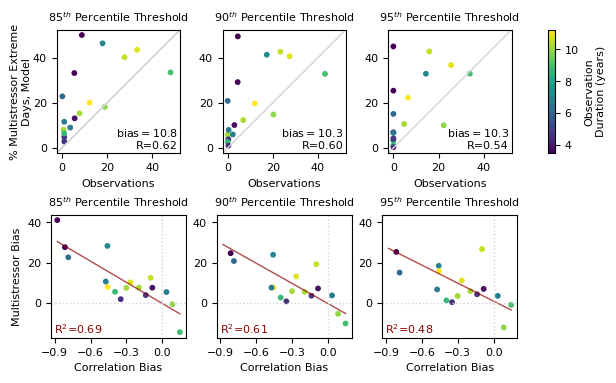

In [11]:
fig,ax=plt.subplots(2,4,figsize=(6.5,4),gridspec_kw={'width_ratios':[1,1,1,.05],'wspace':.3,'hspace':.5})

df=dfperc[85]
iax=ax[0,0]
iax.scatter(df.obspercTpH,df.modpercTpH,c=df.obs_N/365.25,s=10)
viz.squareax(iax)
xl0=iax.get_xlim()
R=np.corrcoef(df.obspercTpH,df.modpercTpH)[1,0]
bb=np.mean(df.modpercTpH.values-df.obspercTpH.values)
iax.text(.98, .02, f"bias$=${bb:.1f}\nR={R:.2f}", ha='right', va='bottom',
         transform=iax.transAxes)
iax=ax[1,0]
xx=df.modcor-df.obscor
yy=df.modpercTpH-df.obspercTpH
m=iax.scatter(xx,yy,c=df.obs_N/365.25,s=10)
ll=cf.linreg(xx,yy)
xl=np.array([np.min(xx),np.max(xx)])
iax.plot(xl,ll.coef[0]+ll.coef[1]*xl,'-',color='darkred',alpha=.7)
iax.text(.02, .02, f"R$^2$={ll.Rsq:.2f}", ha='left', va='bottom',
         color='darkred',transform=iax.transAxes)
xlims=iax.get_xlim()
ylims=iax.get_ylim()
slope, intercept, r_value, p_value, std_err = stats.linregress(xx,yy)
print('slope: ', slope)
print('p<.05?: p=',p_value)

df=dfperc[90]
iax=ax[0,1]
iax.scatter(df.obspercTpH,df.modpercTpH,c=df.obs_N/365.25,s=10)
iax.set_xlim(xl0)
R=np.corrcoef(df.obspercTpH,df.modpercTpH)[1,0]
bb=np.mean(df.modpercTpH.values-df.obspercTpH.values)
iax.text(.98, .02, f"bias$=${bb:.1f}\nR={R:.2f}", ha='right', va='bottom',
         transform=iax.transAxes)
iax=ax[1,1]
xx=df.modcor-df.obscor
yy=df.modpercTpH-df.obspercTpH
m=iax.scatter(xx,yy,c=df.obs_N/365.25,s=10)
ll=cf.linreg(xx,yy)
xl=np.array([np.min(xx),np.max(xx)])
iax.plot(xl,ll.coef[0]+ll.coef[1]*xl,'-',color='darkred',alpha=.7)
iax.text(.02, .02, f"R$^2$={ll.Rsq:.2f}", ha='left', va='bottom',
         color='darkred',transform=iax.transAxes)
iax.set_xlim(xlims)
iax.set_ylim(ylims)
slope, intercept, r_value, p_value, std_err = stats.linregress(xx,yy)
print('slope: ', slope)
print('p<.05?: p=',p_value)

df=dfperc[95]
iax=ax[0,2]
iax.scatter(df.obspercTpH,df.modpercTpH,c=df.obs_N/365.25,s=10)
iax.set_xlim(xl0)
R=np.corrcoef(df.obspercTpH,df.modpercTpH)[1,0]
bb=np.mean(df.modpercTpH.values-df.obspercTpH.values)
iax.text(.98, .02, f"bias$=${bb:.1f}\nR={R:.2f}", ha='right', va='bottom',
         transform=iax.transAxes)
iax=ax[1,2]
xx=df.modcor-df.obscor
yy=df.modpercTpH-df.obspercTpH
m=iax.scatter(xx,yy,c=df.obs_N/365.25,s=10)
ll=cf.linreg(xx,yy)
xl=np.array([np.min(xx),np.max(xx)])
iax.plot(xl,ll.coef[0]+ll.coef[1]*xl,'-',color='darkred',alpha=.7)
iax.text(.02, .02, f"R$^2$={ll.Rsq:.2f}", ha='left', va='bottom',
         color='darkred',transform=iax.transAxes)
iax.set_xlim(xlims)
iax.set_ylim(ylims)
slope, intercept, r_value, p_value, std_err = stats.linregress(xx,yy)
print('slope: ', slope)
print('p<.05?: p=',p_value)

cb=fig.colorbar(m,cax=ax[0,3])
ax[0,3].set_ylabel('Observation\nDuration (years)')


ax[0,0].set_ylabel('% Multistressor Extreme\nDays, Model',labelpad=1)
ax[1,0].set_ylabel('Multistressor Bias')
for iax in ax[1,:-1]:
    iax.set_xlabel('Correlation Bias')
    iax.axhline(0,color='lightgray',linestyle=':')
    iax.axvline(0,color='lightgray',linestyle=':')
for iax in ax[0,:-1]:
    iax.set_xlabel('Observations')
    viz.squareax(iax)
for iax in ax[:,0]:
    iax.set_title('85$^{th}$ Percentile Threshold')
for iax in ax[:,1]:
    iax.set_title('90$^{th}$ Percentile Threshold')
for iax in ax[:,2]:
    iax.set_title('95$^{th}$ Percentile Threshold')
#for iax in ax[0,0]:
# for iax in ax[3,:4]:
#     iax.set_xlabel('Observations')
# for iax in ax[:,:4].flatten():
#     viz.squareax(iax)
# for iax in ax[1:,4]:
ax[-1,-1].remove()
fig.savefig('/home/ebo/OAPMSE/paperFigs/modObsExtremesPercentileSens_Rev.png',dpi=400,bbox_inches='tight')